In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [2]:
class ImagesDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = transforms.ToTensor()(img)
        img.close()
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

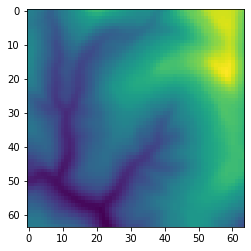

In [4]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [5]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [14]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, 3, padding=1),       
        nn.ReLU(),        
        nn.Conv2d(out_n, out_n, 3, padding=1)
    )
    

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)      
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 32)
        self.enc_linear_1_2 = nn.Linear(4096, 32)
        
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(32, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_2(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_3(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_4(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).cuda()
        return mu + std * esp
        
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [115]:
vae = VAE().cuda()

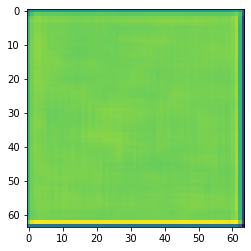

In [116]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [23]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(1942.3420, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2, loss=tensor(589.7929, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3, loss=tensor(824.9695, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4, loss=tensor(317.4703, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5, loss=tensor(288.0256, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6, loss=tensor(184.6395, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7, loss=tensor(134.3269, device='cuda:0', grad_fn=<AddBackward0>)
epoch=8, loss=tensor(158.9061, device='cuda:0', grad_fn=<AddBackward0>)
epoch=9, loss=tensor(121.5466, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(161.1070, device='cuda:0', grad_fn=<AddBackward0>)
epoch=11, loss=tensor(245.2155, device='cuda:0', grad_fn=<AddBackward0>)
epoch=12, loss=tensor(197.4044, device='cuda:0', grad_fn=<AddBackward0>)
epoch=13, loss=tensor(90.1500, device='cuda:0', grad_fn=<AddBackward0>)
epoch=14, loss=tensor(109.3373, device='cuda:0', grad_fn=<Ad

In [40]:
torch.cuda.empty_cache()

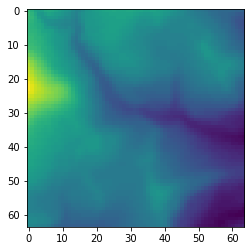

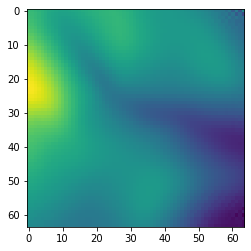

In [27]:
x = dataset[100].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [28]:
#torch.save(vae.state_dict(), './variational_autoencoder_save')

In [117]:
vae.load_state_dict(torch.load('./variational_autoencoder_save'))

<All keys matched successfully>

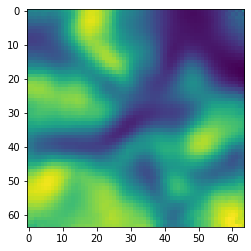

In [125]:
# Generator
code = torch.FloatTensor(1, 32).normal_()

out = vae.decode(code.cuda())
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()